# PyTorch Workflow

## What is we covering?

1. Data (prepare and load)
2. Building model
3. Fitting model to data
4. Making predictions and evaluating a model (also called inference)
5. Saving and loading models
6. Putting all of the above together

In [82]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim

%matplotlib inline

print(torch.__version__)

2.4.0+cu118


## 1. Data

In [83]:
# Create _known_ parameters
weight = 0.7
bias = 0.3

# Create data
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias + 0.01 * torch.randn(X.shape)

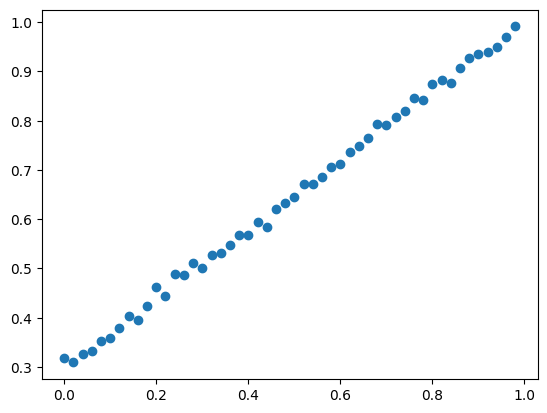

In [84]:
plt.scatter(X, y)

In [85]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [86]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.

    Args:
        train_data (_type_): Training Data
        train_labels (_type_): Training Target
        test_data (_type_): Testing data
        test_labels (_type_): Testing target
        predictions (_type_, optional): If existing, model will predict the target based on Testing data. Defaults to None.
    """
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")
    
    # Plot predictions if they exist
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    
    # Show the legend
    plt.legend(prop={'size': 14})

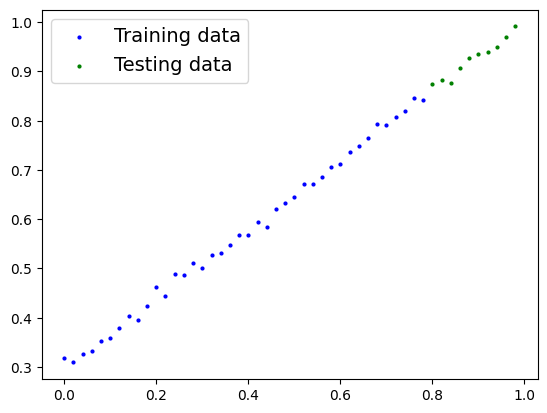

In [87]:
plot_predictions(X_train, y_train, X_test, y_test)

## 2. Building model

In [88]:
class LinearReg(nn.Module):
    def __init__(self):
        super(LinearReg, self).__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [89]:
torch.manual_seed(42)

model_0 = LinearReg()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [90]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions

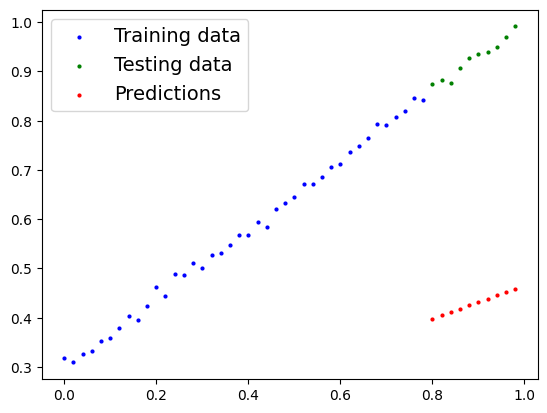

In [91]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

## 3. Training model

In [92]:
loss_fn = nn.L1Loss() # it's MAE loss

optimizer = optim.SGD(params=model_0.parameters(), lr=0.01)

In [93]:
def training_loop(model: nn.Module, X_train, y_train, optimizer, loss_fn, X_test, y_test, epochs):
    torch.manual_seed(42)
    
    train_loss_values, test_loss_values, epoch_count = [], [], []
    
    for epoch in range(epochs):
        # Train
        model_0.train()
        y_pred = model_0(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Test
        model_0.eval()
        with torch.inference_mode():
            test_pred = model_0(X_test)
            test_loss = loss_fn(test_pred, y_test.type(torch.float))
            
            if epoch % 20 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.detach().numpy())
                test_loss_values.append(test_loss.detach().numpy())
                print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")
    
    plt.plot(epoch_count, train_loss_values, label='Train Loss')
    plt.plot(epoch_count, test_loss_values, label='Test Loss')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.legend()
    plt.show()
    
    return model_0
        

Epoch: 0 | Train Loss: 0.3127 | Test Loss: 0.4837
Epoch: 20 | Train Loss: 0.0895 | Test Loss: 0.2205
Epoch: 40 | Train Loss: 0.0460 | Test Loss: 0.1236
Epoch: 60 | Train Loss: 0.0393 | Test Loss: 0.1021
Epoch: 80 | Train Loss: 0.0325 | Test Loss: 0.0805
Epoch: 100 | Train Loss: 0.0259 | Test Loss: 0.0620
Epoch: 120 | Train Loss: 0.0199 | Test Loss: 0.0428
Epoch: 140 | Train Loss: 0.0150 | Test Loss: 0.0305
Epoch: 160 | Train Loss: 0.0111 | Test Loss: 0.0179
Epoch: 180 | Train Loss: 0.0090 | Test Loss: 0.0114


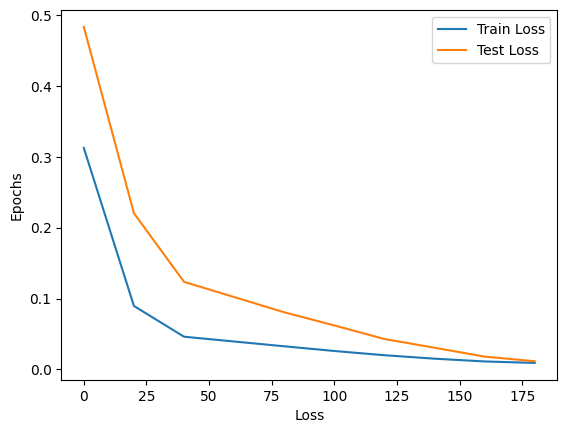

In [94]:
trained_model_0 = training_loop(model_0, X_train, y_train, optimizer, loss_fn, X_test, y_test, epochs=200)

In [95]:
print(f"{model_0.state_dict()=}\n")
print(f'{weight=} | {bias=}')

model_0.state_dict()=OrderedDict({'weights': tensor([0.6943]), 'bias': tensor([0.3003])})

weight=0.7 | bias=0.3


## 4. Making predictions

In [96]:
trained_model_0.eval()

with torch.inference_mode():
    y_preds = trained_model_0(X_test)
    
y_preds

tensor([[0.8558],
        [0.8697],
        [0.8835],
        [0.8974],
        [0.9113],
        [0.9252],
        [0.9391],
        [0.9530],
        [0.9669],
        [0.9808]])

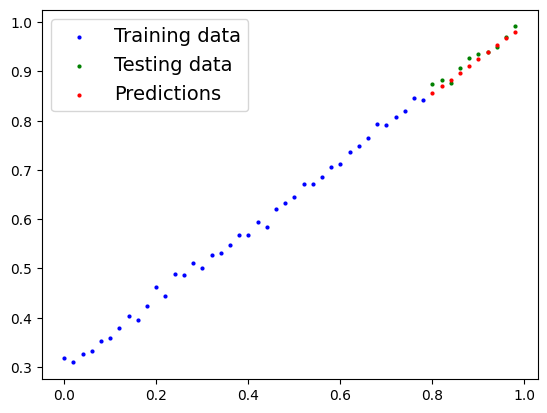

In [97]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

## 5. Saving and Loading model

In [98]:
from pathlib import Path

In [99]:
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "LinearReg_0.pth"
print(f"Saving model to {model_path}/{model_name}")
torch.save(obj=trained_model_0.state_dict(), f=model_path / model_name)

Saving model to models/LinearReg_0.pth


In [100]:
loaded_model_0 = LinearReg()

loaded_model_0.load_state_dict(torch.load(f=model_path/model_name, weights_only=True))

<All keys matched successfully>

In [101]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])